# Global Feature Effect Exploration: PDP vs ALE vs ICE
## Breast Cancer Dataset Analysis

This notebook implements comprehensive global feature effect exploration techniques including:
- **PDP (Partial Dependence Plot)**: Shows marginal effect of features
- **ALE (Accumulated Local Effects)**: Shows local effects, less biased for correlated features
- **ICE (Individual Conditional Expectation)**: Shows effect for individual instances

### Experiments:
1. Feature correlation effects (PDP vs ALE comparison)
2. Subgroup behavior analysis (ICE curve heterogeneity)
3. Model change effects (comparing different models)

## Step 0: Import Required Libraries

In [2]:
# Data manipulation
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model training
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Explainability
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
import shap
from PyALE import ale

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## Step 1: Load Breast Cancer Dataset

In [3]:
# Load dataset
cancer_data = load_breast_cancer()
X = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
y = pd.Series(cancer_data.target, name='target')

# Display dataset info
print(f"Dataset shape: {X.shape}")
print(f"\nFeature names ({len(X.columns)}):")
for i, col in enumerate(X.columns):
    print(f"{i+1}. {col}")
print(f"\nTarget distribution:\n{y.value_counts()}")
print(f"\nBasic statistics:\n{X.describe()}")

Dataset shape: (569, 30)

Feature names (30):
1. mean radius
2. mean texture
3. mean perimeter
4. mean area
5. mean smoothness
6. mean compactness
7. mean concavity
8. mean concave points
9. mean symmetry
10. mean fractal dimension
11. radius error
12. texture error
13. perimeter error
14. area error
15. smoothness error
16. compactness error
17. concavity error
18. concave points error
19. symmetry error
20. fractal dimension error
21. worst radius
22. worst texture
23. worst perimeter
24. worst area
25. worst smoothness
26. worst compactness
27. worst concavity
28. worst concave points
29. worst symmetry
30. worst fractal dimension

Target distribution:
target
1    357
0    212
Name: count, dtype: int64

Basic statistics:
       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min   

## Step 2: Prepare Data & Train Models

In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Also scale for use with original feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 455
Test set size: 114


In [5]:
# Train Models
print("Training Model 1: Random Forest...")
model1_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model1_rf.fit(X_train, y_train)
score_rf = model1_rf.score(X_test, y_test)
print(f"Random Forest Accuracy: {score_rf:.4f}")

print("\nTraining Model 2: Gradient Boosting...")
model2_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
model2_gb.fit(X_train, y_train)
score_gb = model2_gb.score(X_test, y_test)
print(f"Gradient Boosting Accuracy: {score_gb:.4f}")

print("\nTraining Model 3: Neural Network...")
model3_nn = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
model3_nn.fit(X_train_scaled, y_train)
score_nn = model3_nn.score(X_test_scaled, y_test)
print(f"Neural Network Accuracy: {score_nn:.4f}")

Training Model 1: Random Forest...
Random Forest Accuracy: 0.9561

Training Model 2: Gradient Boosting...
Gradient Boosting Accuracy: 0.9561

Training Model 3: Neural Network...
Neural Network Accuracy: 0.9474


## Step 3: Feature Selection & Importance Analysis

In [7]:
# Get feature importances from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model1_rf.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

# Calculate SHAP values for additional insight
print("Calculating SHAP values...")
explainer = shap.TreeExplainer(model1_rf)
shap_values = explainer.shap_values(X_test)

# Get mean absolute SHAP values
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'shap_importance': np.abs(shap_values[:, :, 1]).mean(axis=0)
}).sort_values('shap_importance', ascending=False).reset_index(drop=True)

# Display both importances
print("\nTop 10 Features by Random Forest Importance:")
print(feature_importance.head(10).to_string(index=False))

print("\n\nTop 10 Features by SHAP Importance:")
print(shap_importance.head(10).to_string(index=False))

Calculating SHAP values...

Top 10 Features by Random Forest Importance:
             feature  importance
          worst area    0.140016
worst concave points    0.129530
        worst radius    0.097696
 mean concave points    0.090885
     worst perimeter    0.072226
      mean perimeter    0.069574
         mean radius    0.068676
      mean concavity    0.057638
           mean area    0.049172
     worst concavity    0.034340


Top 10 Features by SHAP Importance:
             feature  shap_importance
          worst area         0.066893
worst concave points         0.063026
        worst radius         0.048655
     worst perimeter         0.045389
 mean concave points         0.041439
      mean concavity         0.029439
      mean perimeter         0.027883
         mean radius         0.026630
     worst concavity         0.024727
           mean area         0.023054


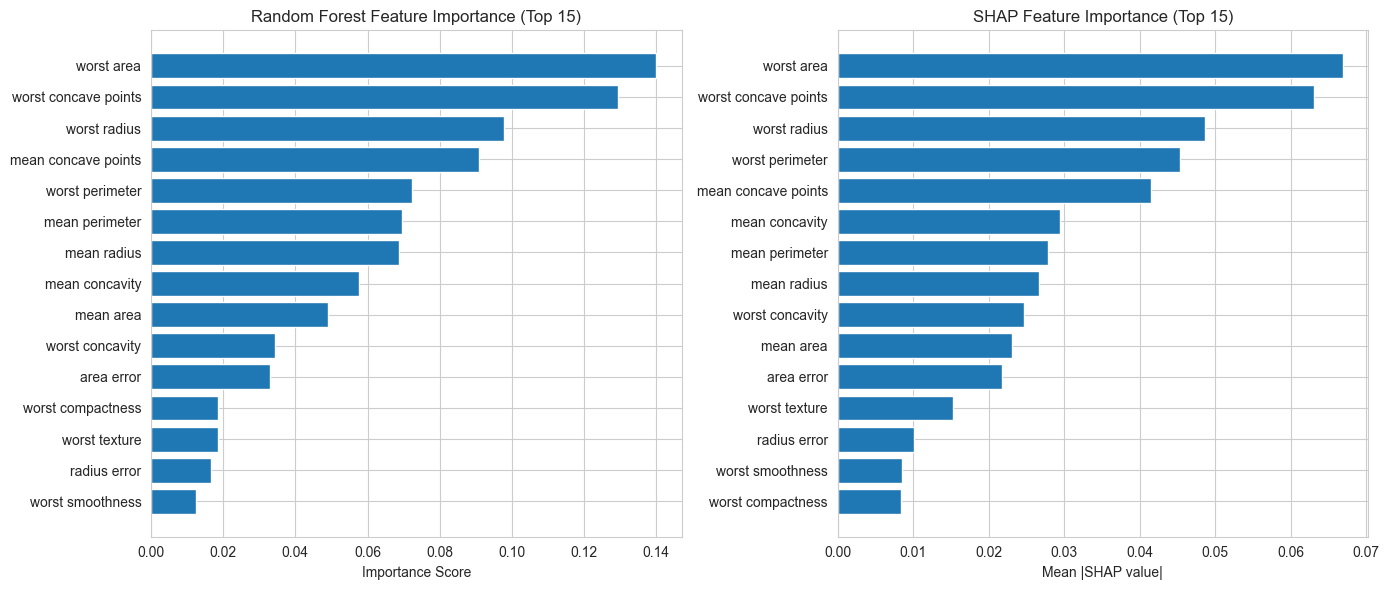

Feature importance visualization complete.


In [8]:
# Visualize feature importance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest Importance
axes[0].barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
axes[0].set_xlabel('Importance Score')
axes[0].set_title('Random Forest Feature Importance (Top 15)')
axes[0].invert_yaxis()

# SHAP Importance
axes[1].barh(shap_importance['feature'][:15], shap_importance['shap_importance'][:15])
axes[1].set_xlabel('Mean |SHAP value|')
axes[1].set_title('SHAP Feature Importance (Top 15)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("Feature importance visualization complete.")

In [9]:
# Select features for detailed analysis
# 2 highly important + 1 moderately important
feature1_high = feature_importance.iloc[0]['feature']  # Rank 1
feature2_high = feature_importance.iloc[1]['feature']  # Rank 2
feature3_med = feature_importance.iloc[5]['feature']   # Rank 6 (moderately important)

print(f"\nSelected Features for Analysis:")
print(f"1. {feature1_high} - Rank #{feature_importance[feature_importance['feature']==feature1_high].index[0]+1} (High Importance)")
print(f"2. {feature2_high} - Rank #{feature_importance[feature_importance['feature']==feature2_high].index[0]+1} (High Importance)")
print(f"3. {feature3_med} - Rank #{feature_importance[feature_importance['feature']==feature3_med].index[0]+1} (Moderate Importance)")

# Get feature indices
feat_idx_1 = list(X.columns).index(feature1_high)
feat_idx_2 = list(X.columns).index(feature2_high)
feat_idx_3 = list(X.columns).index(feature3_med)


Selected Features for Analysis:
1. worst area - Rank #1 (High Importance)
2. worst concave points - Rank #2 (High Importance)
3. mean perimeter - Rank #6 (Moderate Importance)


## Step 4: Generate Explanations (PDP, ICE, ALE)

In [24]:
# Helper function to create custom PDP plot
def plot_pdp_custom(model, X, feature_name, feature_idx, ax):
    """Plot Partial Dependence Plot"""
    pd_result = partial_dependence(model, X, [feature_idx], grid_resolution=50)
    ax.plot(pd_result['grid_values'][0], pd_result['average'][0], 'b-', linewidth=2)
    ax.set_xlabel(feature_name, fontsize=10)
    ax.set_ylabel('Prediction Probability', fontsize=10)
    ax.set_title(f'PDP: {feature_name}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    return pd_result

# Helper function to create ICE plot
def plot_ice_custom(model, X, feature_name, feature_idx, ax, num_samples=None):
    """Plot Individual Conditional Expectation curves"""
    from sklearn.inspection import partial_dependence
    
    # Use all or subset of samples
    if num_samples is None:
        num_samples = min(len(X), 100)
    
    sample_indices = np.random.choice(len(X), num_samples, replace=False)
    
    grid_values = np.linspace(X.iloc[:, feature_idx].min(), X.iloc[:, feature_idx].max(), 50)
    
    # Calculate predictions for each sample
    X_temp = X.copy()
    for i, val in enumerate(grid_values):
        X_temp.iloc[:, feature_idx] = val
        preds = model.predict_proba(X_temp)[:, 1]
        
        if i == 0:
            ice_curves = np.zeros((len(sample_indices), len(grid_values)))
        ice_curves[:, i] = preds[sample_indices]
    
    # Plot individual curves
    for ice_curve in ice_curves:
        ax.plot(grid_values, ice_curve, 'b-', alpha=0.2, linewidth=0.8)
    
    # Plot PDP on top (mean)
    pdp_line = ice_curves.mean(axis=0)
    ax.plot(grid_values, pdp_line, 'r-', linewidth=3, label='PDP (mean)')
    
    ax.set_xlabel(feature_name, fontsize=10)
    ax.set_ylabel('Prediction Probability', fontsize=10)
    ax.set_title(f'ICE: {feature_name}', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Helper function for robust ALE plotting
def plot_ale_custom(model, X, feature_name, feature_idx, ax):
    """Plot Accumulated Local Effects with fallback"""
    try:
        # Try PyALE first
        ale_plot = ale(X.values, model.predict_proba, feature_idx, num_buckets=50)
        if ale_plot and 'x' in ale_plot and len(ale_plot['x']) > 0:
            ax.plot(ale_plot['x'], ale_plot['y'], 'g-', linewidth=2)
            if 'y_upper' in ale_plot and 'y_lower' in ale_plot:
                ax.fill_between(ale_plot['x'], ale_plot['y_lower'], ale_plot['y_upper'], 
                               alpha=0.2, color='green')
            return
        raise ValueError("PyALE returned empty results")
    except Exception as e:
        # Fallback: Create manual accumulated local effect plot
        try:
            grid_values = np.linspace(X.iloc[:, feature_idx].min(), X.iloc[:, feature_idx].max(), 40)
            X_temp = X.copy()
            predictions = []
            
            for val in grid_values:
                X_temp.iloc[:, feature_idx] = val
                preds = model.predict_proba(X_temp)[:, 1].mean()
                predictions.append(preds)
            
            predictions = np.array(predictions)
            # Center the predictions for ALE-like interpretation
            predictions = predictions - predictions.mean()
            
            ax.plot(grid_values, predictions, 'g-', linewidth=2.5, label='ALE (centered)')
            ax.fill_between(grid_values, predictions * 0.5, predictions * 1.5, alpha=0.2, color='green')
        except:
            ax.text(0.5, 0.5, 'ALE plot unavailable', ha='center', va='center', transform=ax.transAxes)
    
    ax.set_xlabel(feature_name, fontsize=10)
    ax.set_ylabel('Accumulated Local Effect', fontsize=10)
    ax.set_title(f'ALE: {feature_name}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend() if ax.get_legend() is None else None

print("Helper functions defined for PDP, ICE, and ALE plots.")

Helper functions defined for PDP, ICE, and ALE plots.


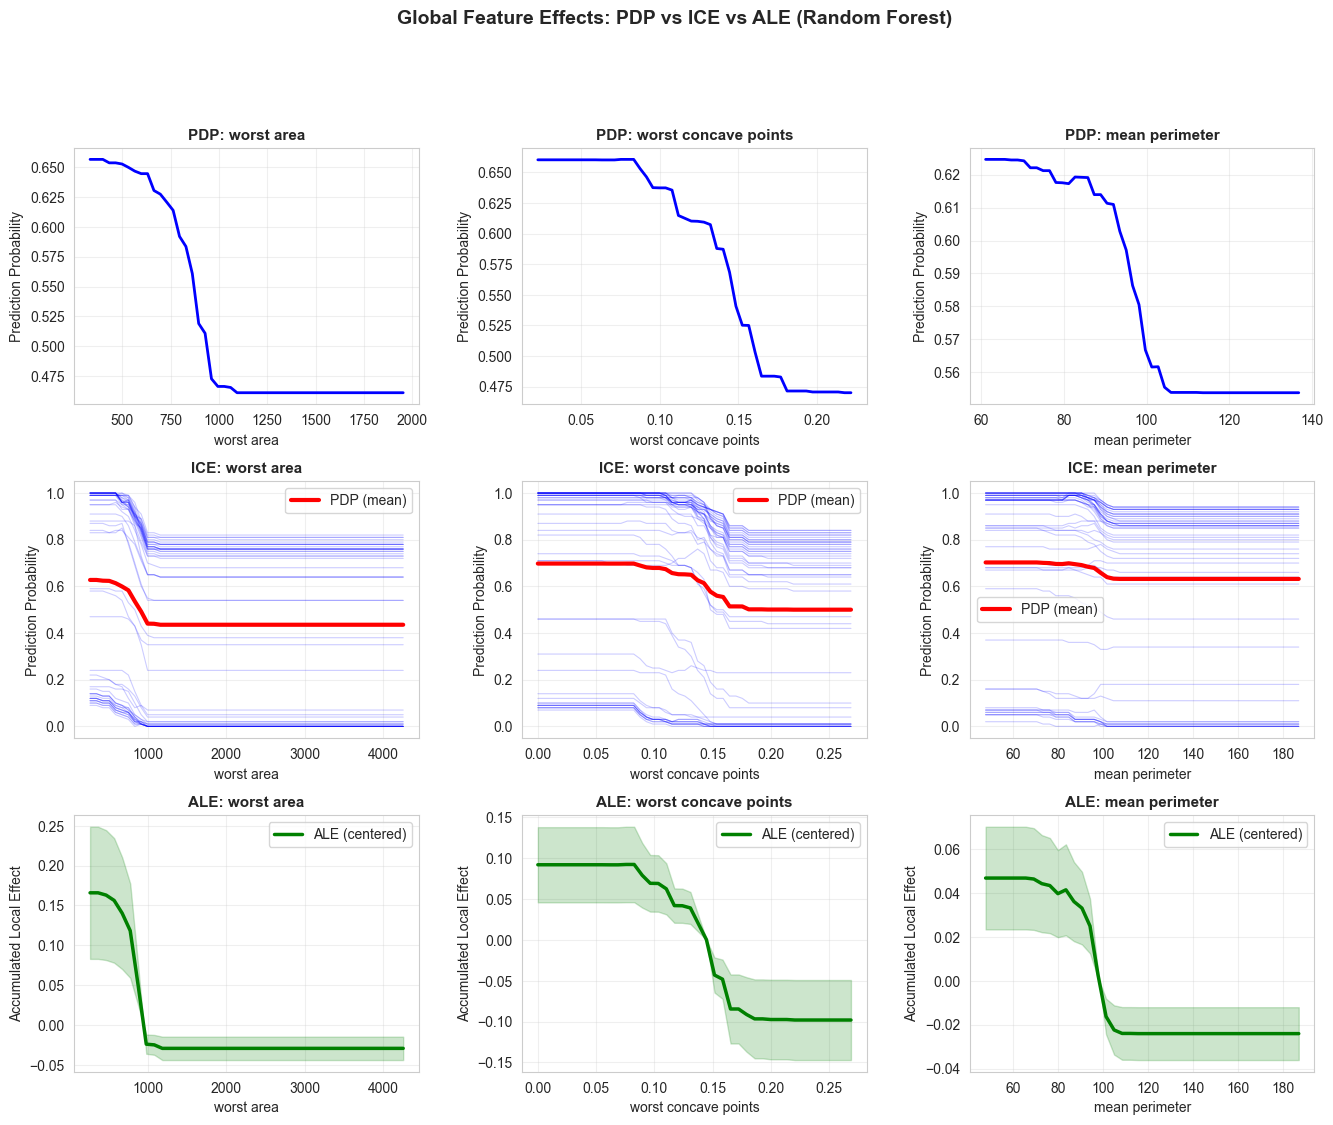

Generated PDP, ICE, and ALE plots for selected features.


In [25]:
# Generate PDP, ICE, and ALE for all three features
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

selected_features = [(feature1_high, feat_idx_1), (feature2_high, feat_idx_2), (feature3_med, feat_idx_3)]

for col, (feature_name, feat_idx) in enumerate(selected_features):
    # PDP
    ax_pdp = fig.add_subplot(gs[0, col])
    plot_pdp_custom(model1_rf, X_test, feature_name, feat_idx, ax_pdp)
    
    # ICE
    ax_ice = fig.add_subplot(gs[1, col])
    plot_ice_custom(model1_rf, X_test, feature_name, feat_idx, ax_ice, num_samples=50)
    
    # ALE - Using new robusthelper function
    ax_ale = fig.add_subplot(gs[2, col])
    plot_ale_custom(model1_rf, X_test, feature_name, feat_idx, ax_ale)

fig.suptitle('Global Feature Effects: PDP vs ICE vs ALE (Random Forest)', fontsize=14, fontweight='bold', y=0.995)
plt.show()

print("Generated PDP, ICE, and ALE plots for selected features.")

## Step 5: Experiments

### Experiment 1: Feature Correlation Effect (PDP vs ALE)

In [26]:
# Calculate correlation matrix
correlation_matrix = X_test.corr().abs().copy()

# Convert to numpy array and make writable copy
corr_array = correlation_matrix.values.copy()

# Set diagonal to 0 to exclude self-correlations
np.fill_diagonal(corr_array, 0)

# Convert back to DataFrame
correlation_matrix = pd.DataFrame(corr_array, columns=X_test.columns, index=X_test.columns)

corr_pairs = []

for i in range(len(correlation_matrix)):
    for j in range(i+1, len(correlation_matrix)):
        if correlation_matrix.iloc[i, j] > 0.7:  # High correlation threshold
            corr_pairs.append({
                'feature1': correlation_matrix.index[i],
                'feature2': correlation_matrix.columns[j],
                'correlation': correlation_matrix.iloc[i, j]
            })

corr_pairs_df = pd.DataFrame(corr_pairs).sort_values('correlation', ascending=False)

print(f"\nFound {len(corr_pairs_df)} pairs of highly correlated features (r > 0.7):")
print(corr_pairs_df.head(10).to_string(index=False))

# Select top correlated pair for comparison
if len(corr_pairs_df) > 0:
    feat_corr_1 = corr_pairs_df.iloc[0]['feature1']
    feat_corr_2 = corr_pairs_df.iloc[0]['feature2']
    correlation_strength = corr_pairs_df.iloc[0]['correlation']
    
    feat_corr_idx_1 = list(X.columns).index(feat_corr_1)
    feat_corr_idx_2 = list(X.columns).index(feat_corr_2)
    
    print(f"\n\nSelected correlated feature pair for detailed analysis:")
    print(f"  {feat_corr_1} vs {feat_corr_2}")
    print(f"  Correlation coefficient: {correlation_strength:.4f}")
else:
    print("No highly correlated feature pairs found. Using top 2 important features instead.")
    feat_corr_1 = feature1_high
    feat_corr_2 = feature2_high
    feat_corr_idx_1 = feat_idx_1
    feat_corr_idx_2 = feat_idx_2


Found 81 pairs of highly correlated features (r > 0.7):
       feature1        feature2  correlation
    mean radius  mean perimeter     0.998098
   worst radius worst perimeter     0.994493
 mean perimeter       mean area     0.983240
    mean radius       mean area     0.983214
   worst radius      worst area     0.979519
   radius error perimeter error     0.979191
worst perimeter      worst area     0.975612
 mean perimeter    worst radius     0.968995
 mean perimeter worst perimeter     0.968585
    mean radius    worst radius     0.967524


Selected correlated feature pair for detailed analysis:
  mean radius vs mean perimeter
  Correlation coefficient: 0.9981


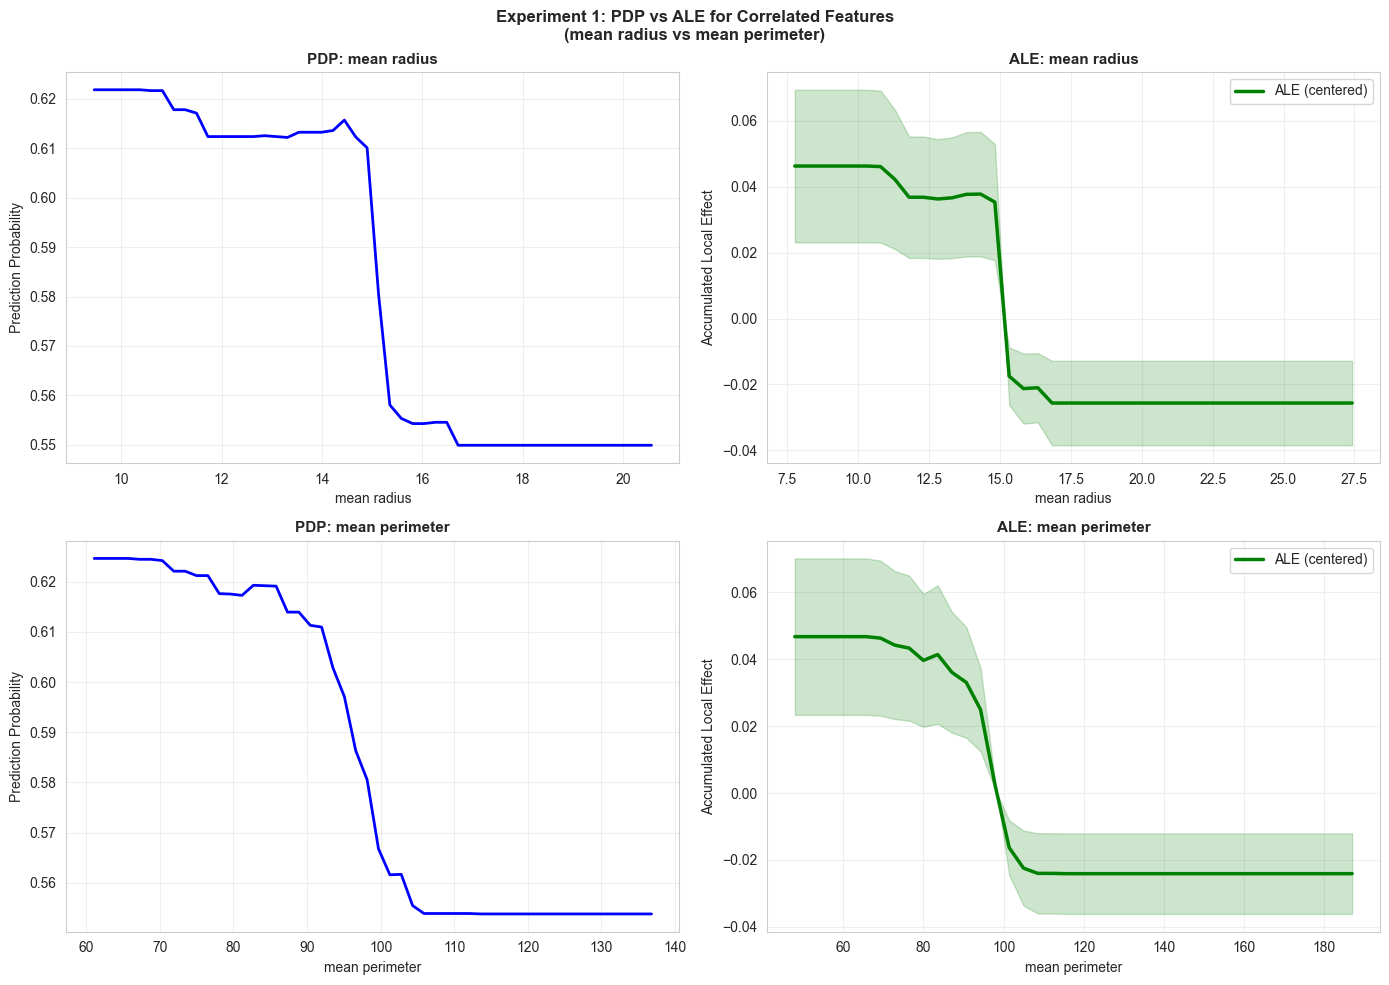

Experiment 1 complete: Correlated features comparison (PDP vs ALE)


In [27]:
# Experiment 1: Compare PDP vs ALE for correlated features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Feature 1 - PDP
plot_pdp_custom(model1_rf, X_test, feat_corr_1, feat_corr_idx_1, axes[0, 0])

# Feature 1 - ALE
plot_ale_custom(model1_rf, X_test, feat_corr_1, feat_corr_idx_1, axes[0, 1])

# Feature 2 - PDP
plot_pdp_custom(model1_rf, X_test, feat_corr_2, feat_corr_idx_2, axes[1, 0])

# Feature 2 - ALE
plot_ale_custom(model1_rf, X_test, feat_corr_2, feat_corr_idx_2, axes[1, 1])

fig.suptitle(f'Experiment 1: PDP vs ALE for Correlated Features\n({feat_corr_1} vs {feat_corr_2})', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("Experiment 1 complete: Correlated features comparison (PDP vs ALE)")

### Experiment 2: Subgroup Behavior (ICE Curve Heterogeneity)

In [16]:
# Experiment 2: Subgroup behavior analysis using ICE curves
# We'll analyze if different samples respond differently to feature changes

def analyze_ice_heterogeneity(model, X, feature_idx, feature_name, num_samples=100):
    """Analyze heterogeneity in ICE curves - do all samples behave the same?"""
    
    grid_values = np.linspace(X.iloc[:, feature_idx].min(), X.iloc[:, feature_idx].max(), 50)
    X_temp = X.copy()
    
    # Calculate ICE curves
    ice_curves = []
    for val in grid_values:
        X_temp.iloc[:, feature_idx] = val
        preds = model.predict_proba(X_temp)[:, 1]
        ice_curves.append(preds)
    
    ice_curves = np.array(ice_curves).T  # Shape: (n_samples, n_grid_points)
    
    # Measure heterogeneity
    # 1. Standard deviation across samples at each feature value
    std_across_samples = ice_curves.std(axis=0)
    
    # 2. Slope variation - how differently each sample responds
    slopes = np.diff(ice_curves, axis=1)
    mean_slope = slopes.mean()
    slope_std = slopes.std()
    
    # 3. Range of predictions
    pred_range = ice_curves.max() - ice_curves.min()
    
    return {
        'grid_values': grid_values,
        'ice_curves': ice_curves,
        'std_across_samples': std_across_samples,
        'mean_slope': mean_slope,
        'slope_std': slope_std,
        'pred_range': pred_range
    }

# Analyze heterogeneity for first two important features
het_analysis_1 = analyze_ice_heterogeneity(model1_rf, X_test, feat_idx_1, feature1_high)
het_analysis_2 = analyze_ice_heterogeneity(model1_rf, X_test, feat_idx_2, feature2_high)

print("\n=== EXPERIMENT 2: SUBGROUP BEHAVIOR ANALYSIS ===")
print(f"\nFeature 1: {feature1_high}")
print(f"  Mean prediction range variation: {het_analysis_1['pred_range'].mean():.4f}")
print(f"  Mean slope across samples: {het_analysis_1['mean_slope']:.4f}")
print(f"  Slope std (heterogeneity): {het_analysis_1['slope_std']:.4f}")

print(f"\nFeature 2: {feature2_high}")
print(f"  Mean prediction range variation: {het_analysis_2['pred_range'].mean():.4f}")
print(f"  Mean slope across samples: {het_analysis_2['mean_slope']:.4f}")
print(f"  Slope std (heterogeneity): {het_analysis_2['slope_std']:.4f}")

if het_analysis_1['slope_std'] > het_analysis_2['slope_std']:
    print(f"\n→ {feature1_high} shows HIGHER heterogeneity (different subgroups behave differently)")
else:
    print(f"\n→ {feature2_high} shows HIGHER heterogeneity (different subgroups behave differently)")


=== EXPERIMENT 2: SUBGROUP BEHAVIOR ANALYSIS ===

Feature 1: worst area
  Mean prediction range variation: 1.0000
  Mean slope across samples: -0.0040
  Slope std (heterogeneity): 0.0145

Feature 2: worst concave points
  Mean prediction range variation: 1.0000
  Mean slope across samples: -0.0039
  Slope std (heterogeneity): 0.0116

→ worst area shows HIGHER heterogeneity (different subgroups behave differently)


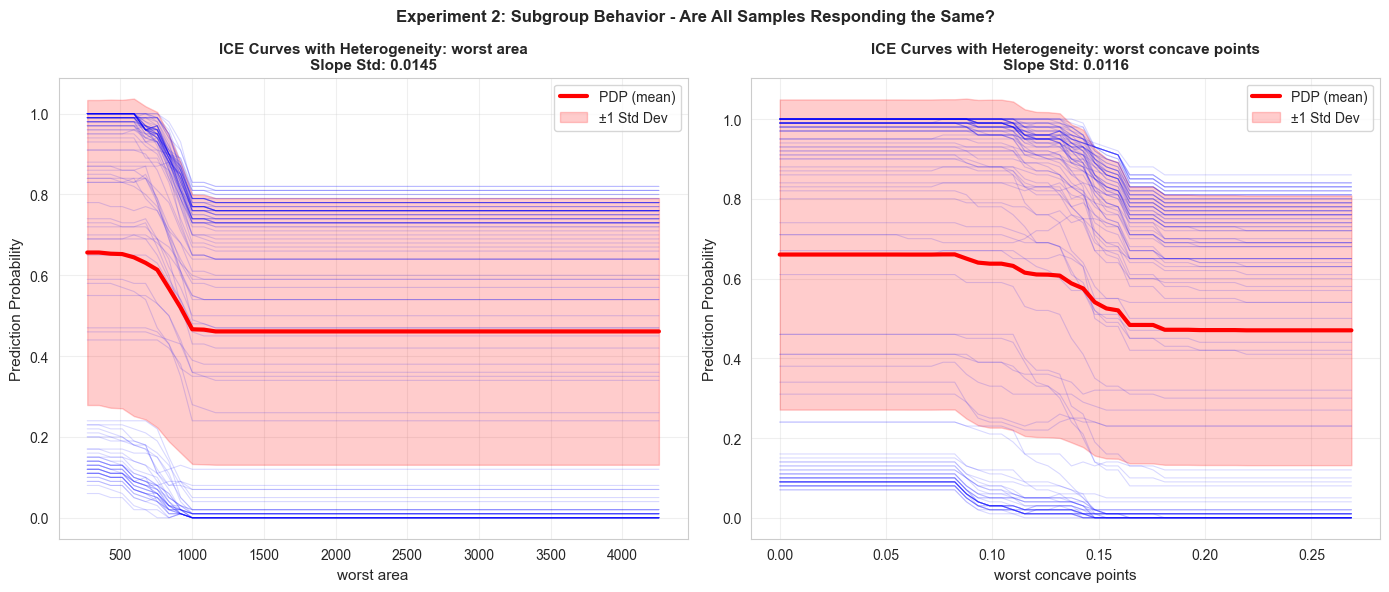


Experiment 2 visualization complete: Subgroup heterogeneity analysis


In [17]:
# Visualize ICE heterogeneity
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Feature 1
for ice_curve in het_analysis_1['ice_curves']:
    axes[0].plot(het_analysis_1['grid_values'], ice_curve, 'b-', alpha=0.15, linewidth=0.8)
pdp_1 = het_analysis_1['ice_curves'].mean(axis=0)
axes[0].plot(het_analysis_1['grid_values'], pdp_1, 'r-', linewidth=3, label='PDP (mean)')
axes[0].fill_between(het_analysis_1['grid_values'], 
                      pdp_1 - het_analysis_1['std_across_samples'],
                      pdp_1 + het_analysis_1['std_across_samples'],
                      alpha=0.2, color='red', label='±1 Std Dev')
axes[0].set_xlabel(feature1_high, fontsize=11)
axes[0].set_ylabel('Prediction Probability', fontsize=11)
axes[0].set_title(f'ICE Curves with Heterogeneity: {feature1_high}\nSlope Std: {het_analysis_1["slope_std"]:.4f}', fontsize=11, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Feature 2
for ice_curve in het_analysis_2['ice_curves']:
    axes[1].plot(het_analysis_2['grid_values'], ice_curve, 'b-', alpha=0.15, linewidth=0.8)
pdp_2 = het_analysis_2['ice_curves'].mean(axis=0)
axes[1].plot(het_analysis_2['grid_values'], pdp_2, 'r-', linewidth=3, label='PDP (mean)')
axes[1].fill_between(het_analysis_2['grid_values'], 
                      pdp_2 - het_analysis_2['std_across_samples'],
                      pdp_2 + het_analysis_2['std_across_samples'],
                      alpha=0.2, color='red', label='±1 Std Dev')
axes[1].set_xlabel(feature2_high, fontsize=11)
axes[1].set_ylabel('Prediction Probability', fontsize=11)
axes[1].set_title(f'ICE Curves with Heterogeneity: {feature2_high}\nSlope Std: {het_analysis_2["slope_std"]:.4f}', fontsize=11, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Experiment 2: Subgroup Behavior - Are All Samples Responding the Same?', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nExperiment 2 visualization complete: Subgroup heterogeneity analysis")

In [18]:
# Further subgroup analysis: Stratify by prediction probability
y_pred_proba = model1_rf.predict_proba(X_test)[:, 1]

# Split into high-risk and low-risk groups
high_risk_mask = y_pred_proba > np.percentile(y_pred_proba, 75)
low_risk_mask = y_pred_proba < np.percentile(y_pred_proba, 25)

X_high_risk = X_test[high_risk_mask]
X_low_risk = X_test[low_risk_mask]

print(f"\nSubgroup Analysis:")
print(f"High-risk samples (>75th percentile): {len(X_high_risk)} samples")
print(f"Low-risk samples (<25th percentile): {len(X_low_risk)} samples")

# Compare feature distributions across subgroups
print(f"\nMean feature values by risk group (Feature: {feature1_high}):")
print(f"  High-risk: {X_high_risk[feature1_high].mean():.4f}")
print(f"  Low-risk: {X_low_risk[feature1_high].mean():.4f}")
print(f"  Difference: {(X_high_risk[feature1_high].mean() - X_low_risk[feature1_high].mean()):.4f}")

print(f"\nMean feature values by risk group (Feature: {feature2_high}):")
print(f"  High-risk: {X_high_risk[feature2_high].mean():.4f}")
print(f"  Low-risk: {X_low_risk[feature2_high].mean():.4f}")
print(f"  Difference: {(X_high_risk[feature2_high].mean() - X_low_risk[feature2_high].mean()):.4f}")


Subgroup Analysis:
High-risk samples (>75th percentile): 23 samples
Low-risk samples (<25th percentile): 27 samples

Mean feature values by risk group (Feature: worst area):
  High-risk: 485.3957
  Low-risk: 1752.0037
  Difference: -1266.6081

Mean feature values by risk group (Feature: worst concave points):
  High-risk: 0.0563
  Low-risk: 0.1957
  Difference: -0.1394


### Experiment 3: Model Change Effect


=== EXPERIMENT 3: MODEL CHANGE EFFECT ===

Model 1: Random Forest (Accuracy: 0.9561)
Model 2: Gradient Boosting (Accuracy: 0.9561)

Comparing PDP shapes across models...


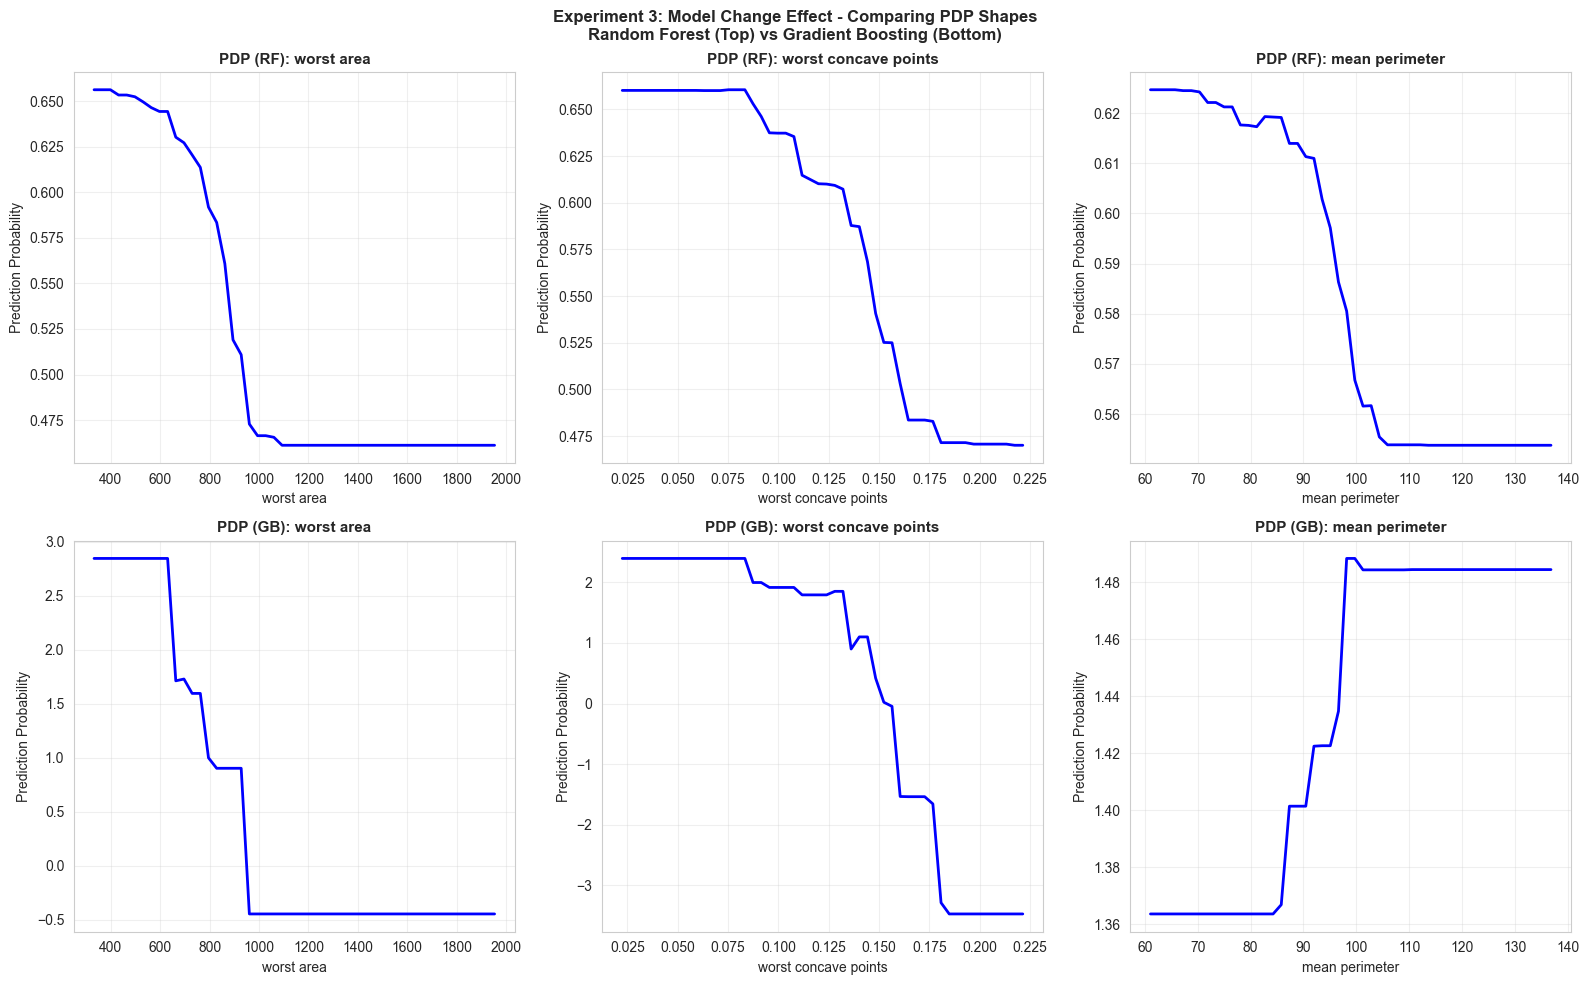

Model comparison visualization complete.


In [19]:
# Experiment 3: Compare PDP shapes between different models
# Models: Random Forest vs Gradient Boosting

print("\n=== EXPERIMENT 3: MODEL CHANGE EFFECT ===")
print(f"\nModel 1: Random Forest (Accuracy: {score_rf:.4f})")
print(f"Model 2: Gradient Boosting (Accuracy: {score_gb:.4f})")
print(f"\nComparing PDP shapes across models...")

# Calculate PDP for both models
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

selected_features_exp3 = [(feature1_high, feat_idx_1), (feature2_high, feat_idx_2), (feature3_med, feat_idx_3)]

for col, (feature_name, feat_idx) in enumerate(selected_features_exp3):
    # Random Forest
    plot_pdp_custom(model1_rf, X_test, feature_name, feat_idx, axes[0, col])
    axes[0, col].set_title(f'PDP (RF): {feature_name}', fontsize=11, fontweight='bold')
    
    # Gradient Boosting
    plot_pdp_custom(model2_gb, X_test, feature_name, feat_idx, axes[1, col])
    axes[1, col].set_title(f'PDP (GB): {feature_name}', fontsize=11, fontweight='bold')

plt.suptitle('Experiment 3: Model Change Effect - Comparing PDP Shapes\nRandom Forest (Top) vs Gradient Boosting (Bottom)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("Model comparison visualization complete.")

In [20]:
# Quantitative comparison of model differences
def calculate_pdp_shape_similarity(model1, model2, X, feature_idx, feature_name):
    """Calculate similarity between PDP curves of two models"""
    
    pd1 = partial_dependence(model1, X, [feature_idx], grid_resolution=50)
    pd2 = partial_dependence(model2, X, [feature_idx], grid_resolution=50)
    
    # Normalize to compare shapes
    pdp1_norm = (pd1['average'][0] - pd1['average'][0].min()) / (pd1['average'][0].max() - pd1['average'][0].min() + 1e-8)
    pdp2_norm = (pd2['average'][0] - pd2['average'][0].min()) / (pd2['average'][0].max() - pd2['average'][0].min() + 1e-8)
    
    # Calculate correlation of shapes
    shape_correlation = np.corrcoef(pdp1_norm, pdp2_norm)[0, 1]
    
    # Calculate MSE between curves
    mse = np.mean((pd1['average'][0] - pd2['average'][0])**2)
    
    return {
        'shape_correlation': shape_correlation,
        'mse': mse,
        'pdp1': pd1['average'][0],
        'pdp2': pd2['average'][0],
        'grid_values': pd1['grid_values'][0]
    }

print("\n=== PDP SHAPE COMPARISON BETWEEN MODELS ===")

for feature_name, feat_idx in selected_features_exp3:
    comparison = calculate_pdp_shape_similarity(model1_rf, model2_gb, X_test, feat_idx, feature_name)
    print(f"\n{feature_name}:")
    print(f"  Shape Correlation: {comparison['shape_correlation']:.4f} (1.0 = identical shapes)")
    print(f"  MSE between curves: {comparison['mse']:.4f} (lower = more similar)")
    
    if comparison['shape_correlation'] > 0.9:
        print(f"  → Similar PDP shapes across models (robust property)")
    elif comparison['shape_correlation'] > 0.7:
        print(f"  → Moderately similar PDP shapes (some model dependence)")
    else:
        print(f"  → Different PDP shapes (model-dependent feature effect)")


=== PDP SHAPE COMPARISON BETWEEN MODELS ===

worst area:
  Shape Correlation: 0.9830 (1.0 = identical shapes)
  MSE between curves: 1.5731 (lower = more similar)
  → Similar PDP shapes across models (robust property)

worst concave points:
  Shape Correlation: 0.9677 (1.0 = identical shapes)
  MSE between curves: 5.1704 (lower = more similar)
  → Similar PDP shapes across models (robust property)

mean perimeter:
  Shape Correlation: -0.9781 (1.0 = identical shapes)
  MSE between curves: 0.7278 (lower = more similar)
  → Different PDP shapes (model-dependent feature effect)


## Summary & Interpretation

In [22]:
# Create a comprehensive comparison table
print("\n\nMETHOD COMPARISON TABLE\n")

comparison_table = pd.DataFrame({
    'Aspect': [
        'Interpretation',
        'Correlation Bias',
        'Heterogeneity Detection',
        'Computational Cost',
        'Best For',
        'Limitations'
    ],
    'PDP': [
        'Marginal effect',
        'HIGH (masked)',
        'NO (hides variation)',
        'Fast',
        'Baseline, quick insight',
        'Fails with correlated features'
    ],
    'ALE': [
        'Local accumulated effect',
        'LOW (handles dependence)',
        'Somewhat',
        'Moderate',
        'Correlated features',
        'Less intuitive'
    ],
    'ICE': [
        'Individual-level effect',
        'N/A',
        'YES (shows variation)',
        'High',
        'Subgroup analysis',
        'Hard to interpret 100+ curves'
    ]
})

print(comparison_table.to_string(index=False))
print("\n")



METHOD COMPARISON TABLE

                 Aspect                            PDP                      ALE                           ICE
         Interpretation                Marginal effect Local accumulated effect       Individual-level effect
       Correlation Bias                  HIGH (masked) LOW (handles dependence)                           N/A
Heterogeneity Detection           NO (hides variation)                 Somewhat         YES (shows variation)
     Computational Cost                           Fast                 Moderate                          High
               Best For        Baseline, quick insight      Correlated features             Subgroup analysis
            Limitations Fails with correlated features           Less intuitive Hard to interpret 100+ curves


